In [1]:
%matplotlib inline
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import Normalize, LogNorm
from sklearn.neighbors.kde import KernelDensity
import pandas as pd
import clemb
from clemb.forward_model import Forwardmodel
from clemb.syn_model import SynModel
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints, unscented_transform
from scipy.optimize import brentq

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

## Synthetic data

In [2]:
# matplotlib.rcParams['axes.prop_cycle']
cl1 = '#1f77b4'
cl2 = '#ff7f0e'
cl3 = '#2ca02c'

In [3]:
def plot_syn_model(df):
    t = df.index
    
    mpl.rcParams['figure.subplot.hspace'] = 0.5
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 10))
    
    axs[0,0].plot(t, df['qi'], ls='--')
    axs[0,0].set_title('Heat input rate')

    axs[0,1].plot(t, df['Mi'])
    axs[0,1].set_title('Meltwater inflow')

    axs[1,0].plot(t, df['M'] + df['M_err'], 'k+')
    axs[1,0].plot(t, df['M'])
    axs[1,0].set_title('Lake mass')

    axs[1,1].plot(t, df['T'] + df['T_err'],'k+')
    axs[1,1].plot(t, df['T'])
    axs[1,1].set_title('Lake temperature')
    
    axs[2,0].plot(t, df['Mo'])
    axs[2,0].set_title('Outflow')
    
    axs[2,1].plot(t, df['z'] + df['z_err'],'k+')
    axs[2,1].plot(t, df['z'])
    axs[2,1].set_title('Lake level')
    
    axs[3,0].plot(t, df['X'] + df['X_err'], 'k+')
    axs[3,0].plot(t, df['X'])
    axs[3,0].set_title('Mg++ total amount')

    axs[3,1].plot(t, df['mevap'])
    axs[3,1].set_title('Evaporated steam')

    axs[4,0].plot(t, df['v'] + df['v_err'], 'k+')
    axs[4,0].plot(t, df['v'])
    axs[4,0].set_title('Lake volume')
    
    axs[4,1].plot(t, df['Mg'] + df['Mg_err'], 'k+')
    axs[4,1].plot(t, df['Mg'])
    axs[4,1].set_title('Mg++ concentration')

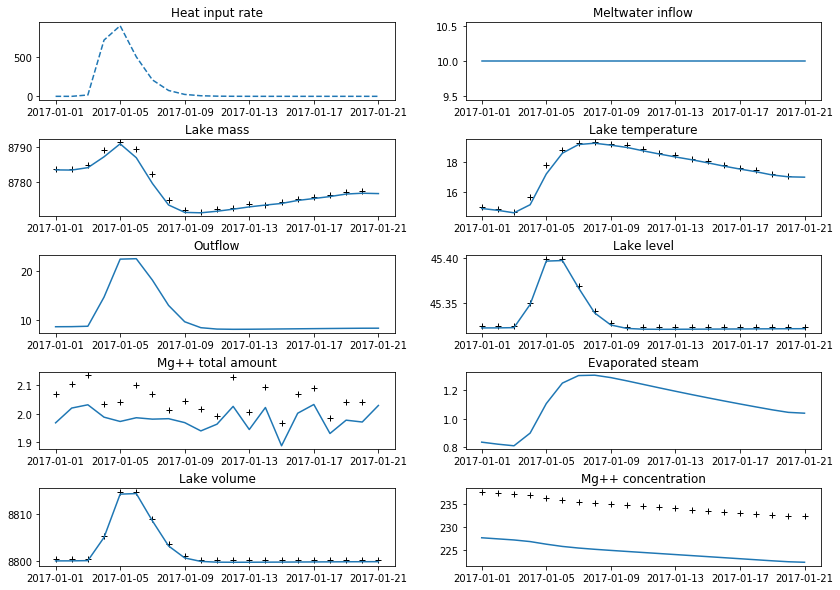

In [4]:
df = SynModel().run(1000., nsteps=100, integration_method='rk4', 
                    gradient=True, mode='gamma', addnoise=True,
                    estimatenoise=True)
plot_syn_model(df)

In [29]:
def fullness_inv(v):
    """
    Compute lake level from lake volume.
    """
    def f(h, v):
        return (4.747475*np.power(h, 3)-34533.8*np.power(h, 2) + 83773360.*h-67772125000.)/1000. - v
    return brentq(f, 2400, 2600, args=v)


class Fx:
    
    def __init__(self):
        s = SynModel()
        self.fm = Forwardmodel(method='rk4', mass2area=s.mass2area)

    def run(self, x, dt, date, h=6.0, ws=4.5):
        """
        Forward model lake temperature
        """
        y = np.zeros(8)
        y[0:6] = x[0:6]
        y[6] = h
        y[7] = ws
        dp = [0.] * 5
        dp[0] = x[6]
        y_next = self.fm.integrate(y, date, dt, dp)
        return np.r_[y_next[0:6], x[6]]


def h_x(x):
    """
    Measurement function
    """
    return [x[0], x[1], x[2]] 


def smooth(data, Q, X0):
    dt = (data.index[1] - data.index[0])/pd.Timedelta('1D')
    nvar = len(X0)
    points = MerweScaledSigmaPoints(n=nvar, alpha=1e-1, beta=2., kappa=0.)
    F = Fx()
    kf = UKF(dim_x=nvar, dim_z=3, dt=dt, fx=F.run, hx=h_x, points=points)
    P = np.eye(nvar)
    T_err = data.iloc[0]['T_err']
    M_err = data.iloc[0]['M_err']
    X_err = data.iloc[0]['X_err']
    kf.x = X0
    kf.Q = Q
    kf.P = 1e3
    kf.R = np.eye(3)*[T_err*T_err, M_err*M_err, X_err*X_err]*dt*dt
    nperiods=data.shape[0]-1
    Xs = np.zeros((nperiods, nvar))
    Ps = np.zeros((nperiods, nvar, nvar))
    for i in range(nperiods):
        _fx = partial(F.run, h=6.0, ws=4.5, date=data.index[i])
        kf.fx = _fx
        try:
            sigmas = kf.points_fn.sigma_points(kf.x, kf.P)
        except Exception as e:
            print(i)
            print(sigmas)
            print(kf.x)
            print(Xs[i-2,:])
            print(Xs[0,:])
            raise e
        if True:
            sigmas[:,0:6] = np.where(sigmas[:,0:6] < 0., 0., sigmas[:,0:6])
        for k, s in enumerate(sigmas):
            try:
                kf.sigmas_f[k] = kf.fx(s, dt)
            except ValueError as ve:
                print(s)
                print(kf.sigmas_f)
                print(kf.fx)
                raise ve
        kf.x, kf.P = unscented_transform(kf.sigmas_f,
                                         kf.Wm, kf.Wc, kf.Q,
                                         kf.x_mean, kf.residual_x)
        # save prior
        kf.x_prior = np.copy(kf.x)
        kf.P_prior = np.copy(kf.P)
        T_u = data.iloc[i+1]['T']
        M_u = data.iloc[i+1]['M']
        X_u = data.iloc[i+1]['X']
        kf.update([T_u, M_u, X_u])
        Xs[i,:] = kf.x
        Ps[i, :, :] = kf.P

    # Smoothing
    xs, ps = Xs.copy(), Ps.copy()
    log_lh = 0
    if True:
        n, dim_x = xs.shape
        dim_z = 3
        num_sigmas = kf._num_sigmas
        dts = [kf._dt] * n
        sigmas_f = np.zeros((num_sigmas, dim_x))
        Ks = np.zeros((n, dim_x, dim_x))
        res = np.zeros((n, dim_x))

        for k in reversed(range(n-1)):
            # create sigma points from state estimate, pass through state func
            sigmas = kf.points_fn.sigma_points(xs[k], ps[k])
            for i in range(num_sigmas):
                sigmas_f[i] = kf.fx(sigmas[i], dts[k], date=data.index[k])
            xb, Pb = unscented_transform(sigmas_f, kf.Wm, kf.Wc, kf.Q)

            # compute cross variance
            Pxb = 0
            for i in range(num_sigmas):
                y = kf.residual_x(sigmas_f[i], xb)
                z = kf.residual_x(sigmas[i], Xs[k])
                Pxb += kf.Wc[i] * np.outer(z, y)

            # compute gain
            K = np.dot(Pxb, kf.inv(Pb))

            # update the smoothed estimates
            xs[k] += np.dot(K, kf.residual_x(xs[k+1], xb))
            res[k] = kf.residual_x(xs[k+1], xb)
            ps[k] += np.dot(K, ps[k+1] - Pb).dot(K.T)

            # recompute S based on the smoothed state values
            sigmas_h = np.zeros((num_sigmas, dim_z))
            sigmas = kf.points_fn.sigma_points(xs[k], ps[k])
            for i in range(num_sigmas):
                sigmas_h[i] = kf.hx(sigmas[i])

            # mean and covariance of prediction passed through unscented transform
            zp, kf.S = unscented_transform(sigmas_h, kf.Wm, kf.Wc, kf.R)
            Ks[k] = K
            log_lh += kf.log_likelihood
    return xs, ps, Xs, Ps, log_lh


def lh_fun(var, sid, data):
    dt = (data.index[1] - data.index[0])/pd.Timedelta('1D')
    T_Q = var[0]
    M_Q = var[1]
    X_Q = var[2]
    qi_Q = var[3]
    Mi_Q = var[4]
    Mo_Q = var[5]
    dqi_Q = var[6]
    Q = np.eye(7)*[T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q]*dt*dt
    (T, T_err, p, p_err, a, a_err, 
     M, M_err, v, v_err, X, X_err, 
     Mg, Mg_err, z, z_err, W, H, dv,
     Mi, Mo, mevap, qi) = data.iloc[0]
    dqi = 1e-1
    X0 = [T, M, X, qi*0.0864, Mi, Mo, dqi]
    try:
        xs, ps, Xs, Ps, log_lh = smooth(data, Q)
    except:
        return 1e-10
    return log_lh
    
dt = (df.index[1] - df.index[0])/pd.Timedelta('1D')
Q = np.eye(7)*[1e-3, 1e-3, 1e-3, 1e-10, 1e1, 1e1, 1e4]*dt*dt
#Q[4,5] = -0.8
#Q[5,4] = -0.8
(T, T_err, p, p_err, a, a_err, 
 M, M_err, v, v_err, X, X_err, 
 Mg, Mg_err, z, z_err, W, H, dv,
 Mi, Mo, mevap, qi) = df.iloc[0]
dqi = 1e-1
dMi = 1e-1
dMo = 1e-1
X0 = [T, M, X, qi*0.0864, Mi, Mo, dqi]
xs, ps, Xs, Ps, log_lh = smooth(df, Q, X0)
_fn = partial(lh_fun, data=df)
_fn(np.diag(Q)/(dt*dt), 1)



1e-10

/usr/local/anaconda3/envs/da/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


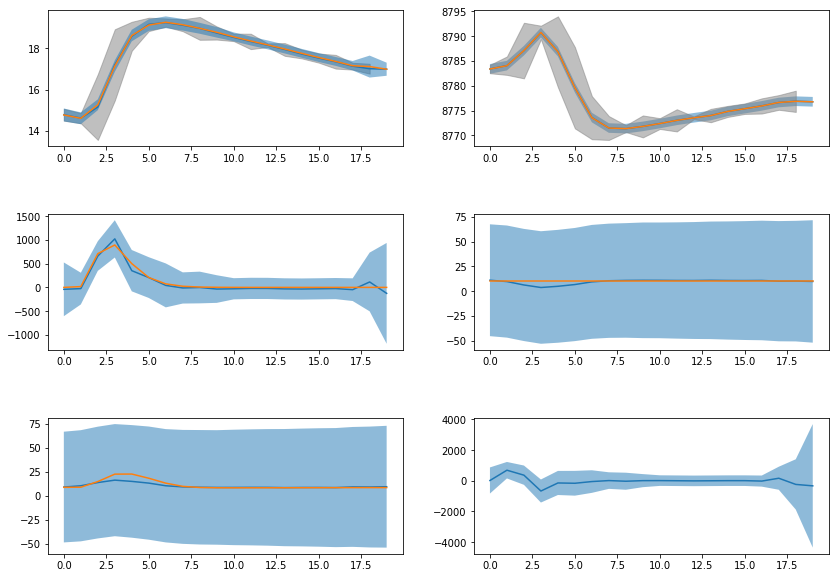

In [30]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,10))

if False:
    xs = Xs
    ps = Ps
pss = np.sqrt(ps)
axs[0,0].plot(df['T'].values[1:])
axs[0,0].fill_between(np.arange(df['T'].values.size-1), df['T'].values[1:] - 3*df['T_err'].values[1:],
                      df['T'].values[1:] + 3*df['T_err'].values[1:], alpha=0.5,
                      color='grey')
axs[0,0].plot(xs[:,0])
axs[0,0].fill_between(np.arange(xs.shape[0]), xs[:,0]-3*pss[:,0,0],
                      xs[:,0]+3*pss[:,0,0], alpha=0.5)

axs[0,1].plot(xs[:,1])
axs[0,1].fill_between(np.arange(xs.shape[0]), xs[:,1]-3*pss[:,1,1],
                      xs[:,1]+3*pss[:,1,1], alpha=0.5)
axs[0,1].plot(df['M'].values[1:])
axs[0,1].fill_between(np.arange(df['M'].values.size-1), df['M'].values[1:] - 3*df['M_err'].values[1:],
                      df['M'].values[1:] + 3*df['M_err'].values[1:], alpha=0.5,
                      color='grey')

axs[1,0].plot(xs[:,3]/0.0864)
axs[1,0].fill_between(np.arange(xs.shape[0]), (xs[:,3]-3*pss[:,3,3])/0.0864,
                      (xs[:,3]+3*pss[:,3,3])/0.0864, alpha=0.5)
axs[1,0].plot(df['qi'].values[1:])

axs[1,1].plot(xs[:,4])
axs[1,1].fill_between(np.arange(xs.shape[0]), xs[:,4]-3*pss[:,4,4],
                      xs[:,4]+3*pss[:,4,4], alpha=0.5)
axs[1,1].plot(df['Mi'].values[1:])

axs[2,0].plot(xs[:,5])
axs[2,0].fill_between(np.arange(xs.shape[0]), xs[:,5]-3*pss[:,5,5],
                      xs[:,5]+3*pss[:,5,5], alpha=0.5)
axs[2,0].plot(df['Mo'].values[1:])

axs[2,1].plot(xs[:,6]/0.0864)
axs[2,1].fill_between(np.arange(xs.shape[0]), (xs[:,6]-3*pss[:,6,6])/0.0864,
                      (xs[:,6]+3*pss[:,6,6])/0.0864, alpha=0.5)


In [31]:
if False:
    from nsampling import NestedSampling, Uniform, Normal

    T_Q = Uniform('T_Q', 1e-5, 1e-1)
    M_Q = Uniform('M_Q', 1e-5, 1e-1)
    X_Q = Uniform('X_Q', 1e-5, 1e-1)
    qi_Q = Uniform('qi_Q', 1e-8, 1.)
    Mi_Q = Uniform('Mi_Q', 1e-8, 1.)
    Mo_Q = Uniform('Mo_Q', 1e-8, 1.)
    dqi_Q = Uniform('dqi_Q',1e-1, 1e6)

    ns = NestedSampling()
    rs = ns.explore([T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q], 10, 300, likelihood=_fn)


In [32]:
if False:
    [T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q] = rs.get_samples()[-1].get_value()
    [T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q] = rs.getexpt()
    dt = (df.index[1] - df.index[0])/pd.Timedelta('1D')
    Q = np.eye(7)*[T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q]*dt*dt
    xs, ps, Xs, Ps, log_lh = smooth(df, Q)
    log_lh

In [33]:
if False:
    maxlog = 1e-30
    lhs = []
    zs = []
    for s in rs.get_samples():
        lh = s.get_logL()
        lhs.append(lh)
        zs.append(s.get_logZ())
        if lh>maxlog:
            maxlog = lh
            vals = s.get_value()

    [T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q] = vals
    Q = np.eye(7)*[T_Q, M_Q, X_Q, qi_Q, Mi_Q, Mo_Q, dqi_Q]*dt*dt
    xs, ps, Xs, Ps, log_lh = smooth(df, Q)
    plt.plot(zs)
    plt.plot(lhs)

## Real data

In [34]:
from clemb.data import LakeData

In [35]:
ld = LakeData()
df_rd = ld.get_data_fits('2019-01-01', '2019-08-02', smoothing='dv')

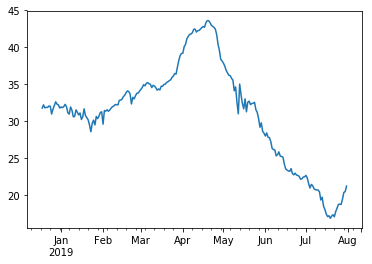

In [36]:
df_rd['T'].plot()

In [37]:
df_rd.dropna(inplace=True)

In [43]:
T0 = df_rd.iloc[0]['T']
M0 = df_rd.iloc[0]['M']
X0 = df_rd.iloc[0]['X']
Mi0 = 10.
Mo0 = 10.
qi0 = 100.
dqi0 = 1e-1
dt = (df_rd.index[1] - df_rd.index[0])/pd.Timedelta('1D')
Q = np.eye(7)*[1e-3, 1e-3, 1e-3, 1e-10, 1e1, 1e1, 1.]*dt*dt
X0 = [T0, M0, X0, qi0*0.0864, Mi0, Mo0, dqi0]
xs, ps, Xs, Ps, log_lh = smooth(df_rd, Q, X0)

In [44]:
import xarray as xr
rs = xr.open_dataset('../../../tests/data/forward_2018-04-01_2019-08-02.nc')

/usr/local/anaconda3/envs/da/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


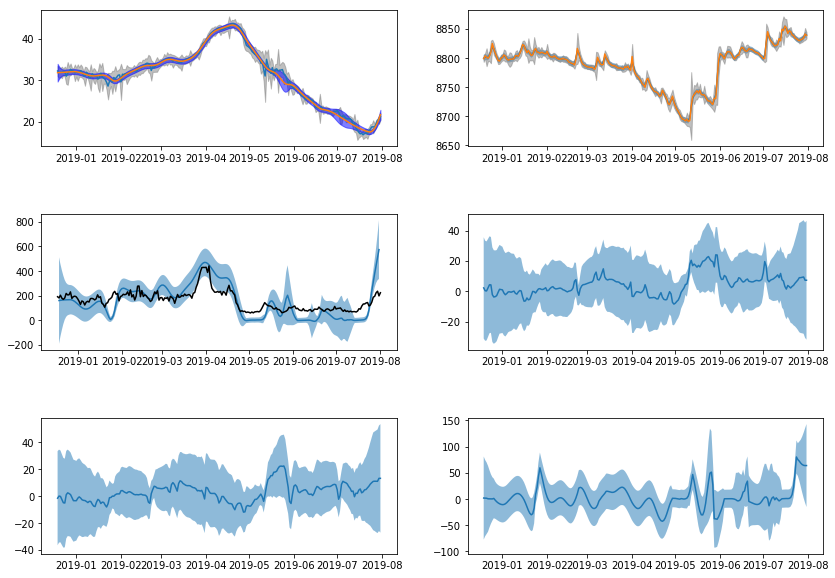

In [45]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,10))

if False:
    xs = Xs
    ps = Ps
pss = np.sqrt(ps)
axs[0,0].plot(df_rd.index[1:], df_rd['T'].values[1:])
axs[0,0].fill_between(df_rd.index[1:], df_rd['T'].values[1:] - 3*df_rd['T_err'].values[1:],
                      df_rd['T'].values[1:] + 3*df_rd['T_err'].values[1:], alpha=0.5,
                      color='grey')
axs[0,0].plot(df_rd.index[1:],xs[:,0])
axs[0,0].fill_between(df_rd.index[1:], xs[:,0]-3*pss[:,0,0],
                      xs[:,0]+3*pss[:,0,0], alpha=0.5, color='blue')

axs[0,1].plot(df_rd.index[1:], xs[:,1])
axs[0,1].fill_between(df_rd.index[1:], xs[:,1]-3*pss[:,1,1],
                      xs[:,1]+3*pss[:,1,1], alpha=0.5)
axs[0,1].plot(df_rd.index[1:], df_rd['M'].values[1:])
axs[0,1].fill_between(df_rd.index[1:], df_rd['M'].values[1:] - 3*df_rd['M_err'].values[1:],
                      df_rd['M'].values[1:] + 3*df_rd['M_err'].values[1:], alpha=0.5,
                      color='grey')

starttime = df_rd.index[0].to_datetime64()
idx = rs['dates'] >= starttime
q_in = rs['exp'].loc[idx,'q_in']
qdates = rs['dates'][idx]
axs[1,0].plot(df_rd.index[1:], xs[:,3]/0.0864)
axs[1,0].plot(qdates, q_in, 'k-')
axs[1,0].fill_between(df_rd.index[1:], (xs[:,3]-3*pss[:,3,3])/0.0864,
                      (xs[:,3]+3*pss[:,3,3])/0.0864, alpha=0.5)

axs[1,1].plot(df_rd.index[1:], xs[:,4])
axs[1,1].fill_between(df_rd.index[1:], xs[:,4]-3*pss[:,4,4],
                      xs[:,4]+3*pss[:,4,4], alpha=0.5)

axs[2,0].plot(df_rd.index[1:], xs[:,5])
axs[2,0].fill_between(df_rd.index[1:], xs[:,5]-3*pss[:,5,5],
                      xs[:,5]+3*pss[:,5,5], alpha=0.5)

axs[2,1].plot(df_rd.index[1:], xs[:,6]/0.0864)
axs[2,1].fill_between(df_rd.index[1:], (xs[:,6]-3*pss[:,6,6])/0.0864,
                      (xs[:,6]+3*pss[:,6,6])/0.0864, alpha=0.5)
